In [1]:
!pip install -q torch_summary
!pip install -q torch_snippets
!pip install -q scipy
from google.colab import files
files.upload() # upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
print('downloading data...')
!kaggle datasets download -d tthien/shanghaitech-with-people-density-map/
print('unzipping data...')
!unzip -qq shanghaitech-with-people-density-map.zip

     |████████████████████████████████| 49 kB 2.5 MB/s 
     |████████████████████████████████| 58 kB 3.4 MB/s 
     |████████████████████████████████| 11.1 MB 32.1 MB/s 
     |████████████████████████████████| 948 kB 44.5 MB/s 
     |████████████████████████████████| 232 kB 53.5 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 51 kB 7.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


Saving kaggle.json to kaggle.json
kaggle.json
downloading data...
100% 4.78G/4.79G [01:10<00:00, 72.4MB/s]
100% 4.79G/4.79G [01:10<00:00, 72.4MB/s]
unzipping data...


In [2]:
from torch_snippets import *
from torchsummary import summary
import torch
import torch.nn as nn
from torchvision import models
from sklearn.model_selection import train_test_split
from matplotlib import cm
from torchvision import transforms
from PIL import Image
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import torch
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
part_A = Glob('shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/');

image_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/'
heatmap_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth-h5/'
gt_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = T.Compose([
    T.ToTensor()
])

class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = f'{image_folder}/{_stem}.jpg'
        heatmap_path = f'{heatmap_folder}/{_stem}.h5'
        gt_path = f'{gt_folder}/GT_{_stem}.mat'

        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0,0][0,0][0])

        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8)*64
        return image.copy(), gt.copy(), pts

    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)

    def choose(self):
        return self[randint(len(self))]

from sklearn.model_selection import train_test_split
trn_stems, val_stems = train_test_split(stems(Glob(image_folder)), random_state=10)

trn_ds = Crowds(trn_stems)
val_ds = Crowds(val_stems)

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [4]:
ims, gts, pts = next(iter(trn_dl))
print(ims.shape)
print(gts.shape)
print(pts.shape)

torch.Size([1, 3, 405, 609])
torch.Size([1, 1, 50, 76])
torch.Size([1])


In [5]:
def create_layers(end_type,ni=3,batch_norm=False,dilation=False):
  if dilation:
    d_rate = 2
  else:
    d_rate = 1
  layers = []
  for no in end_type:
    if no == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      conv2d = nn.Conv2d(ni,no,kernel_size=3,padding=d_rate,dilation=d_rate)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(no), nn.ReLU(inplace=True)]
      else:
        layers += [conv2d, nn.ReLU(inplace=True)]
      ni = no
  return nn.Sequential(*layers)

In [6]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = create_layers(self.frontend_feat)
        self.backend = create_layers(self.backend_feat,ni = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [7]:
def batch_train(model,data,optimizer,criterion):
  model.train()
  ims, gts, pts = data
  _gts = model(ims)
  loss = criterion(_gts,gts)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  pts_loss = nn.L1Loss()(_gts.sum(),gts.sum())
  return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model,data,criterion):
  model.eval()
  ims, gts, pts = data
  _gts = model(ims)
  loss = criterion(_gts,gts)
  pts_loss = nn.L1Loss()(_gts.sum(),gts.sum())
  return loss.item(), pts_loss.item()

In [8]:
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 5

log = Report(n_epochs)
for epoch in range(n_epochs):
  N = len(trn_dl)
  for ix, data in enumerate(trn_dl):
    loss, pts_loss = batch_train(model,data,optimizer,criterion)
    log.record(epoch+(ix+1)/N, trn_loss=loss, trn_pts=pts_loss, end='\r')
  
  for ix, data in enumerate(val_dl):
    loss, pts_loss = validate_batch(model,data,criterion)
    log.record(epoch+(ix+1)/N, val_loss=loss, val_pts=pts_loss, end='\r')

  log.report_avgs(epoch+1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

EPOCH: 1.000	trn_loss: 0.051	trn_pts: 434.280	val_loss: 0.048	val_pts: 329.352	(54.61s - 218.44s remaining)
EPOCH: 2.000	trn_loss: 0.043	trn_pts: 300.281	val_loss: 0.042	val_pts: 248.826	(104.53s - 156.79s remaining)
EPOCH: 3.000	trn_loss: 0.038	trn_pts: 215.926	val_loss: 0.036	val_pts: 147.669	(155.00s - 103.34s remaining)
EPOCH: 4.000	trn_loss: 0.035	trn_pts: 170.648	val_loss: 0.034	val_pts: 141.488	(205.36s - 51.34s remaining)
EPOCH: 5.000	trn_loss: 0.034	trn_pts: 154.477	val_loss: 0.033	val_pts: 137.077	(255.86s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2500.67it/s]


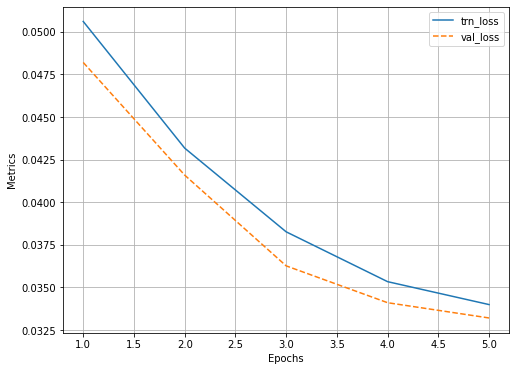

100%|██████████| 106/106 [00:00<00:00, 2275.87it/s]


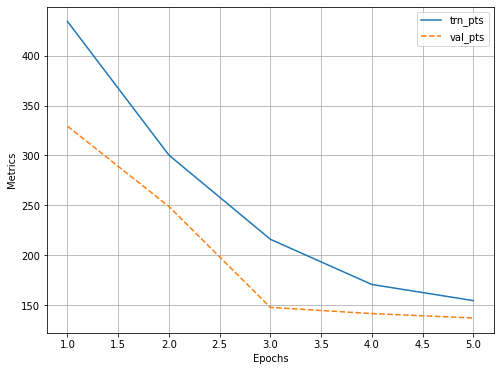

In [9]:
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_pts,val_pts'.split(','))

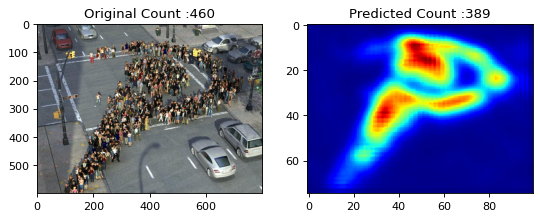

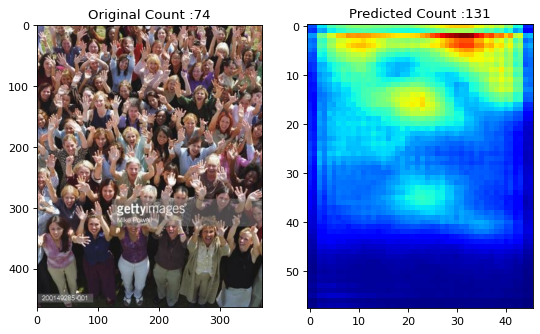

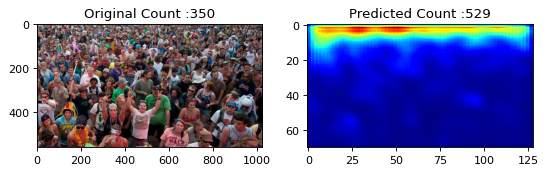

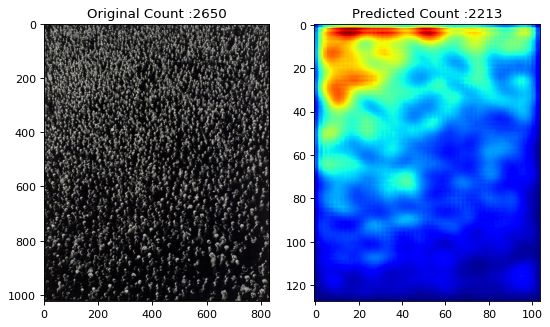

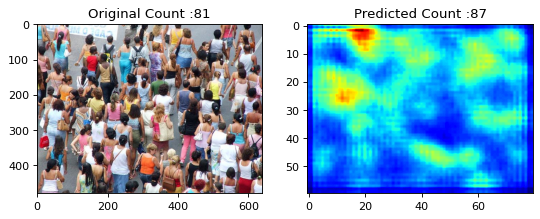

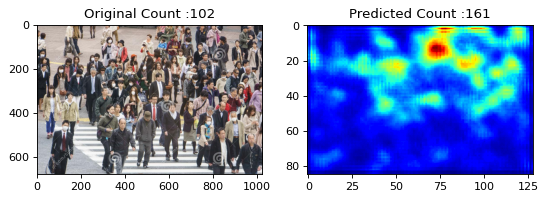

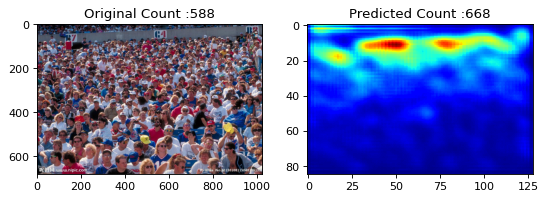

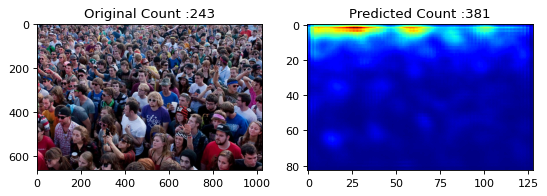

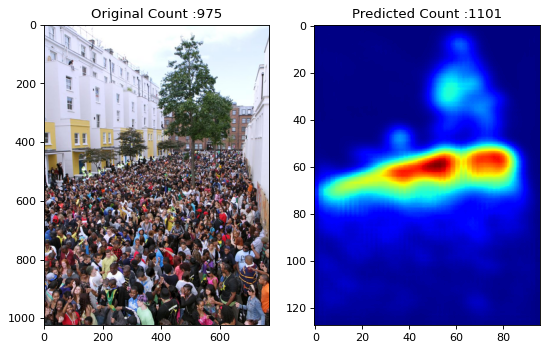

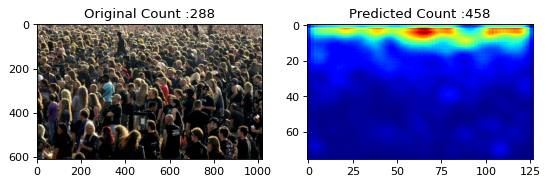

In [25]:
from matplotlib.pyplot import figure

for _ in range(10):
  figure(figsize=(8, 6), dpi=80)
  ims, gts, pts = next(iter(val_dl))

  plt.subplot(1,2,1)
  img = ims[0,:,:,:]
  img = img.permute(1,2,0)
  plt.imshow(img.cpu())
  plt.title("Original Count :"+str(int(pts)))

  output = model(ims)
  temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
  plt.subplot(1,2,2)
  plt.imshow(temp,cmap=CM.jet)
  plt.title("Predicted Count :"+str(int(output.detach().cpu().sum().numpy())))